In [2]:
#Load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.9 MB/s eta 0:00:00


# Library

In [ ]:
!pip install pytorch-ignite
!pip install torchmetrics

In [ ]:
!pip install tifffile

In [107]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

from ignite.metrics import mIoU
from torchmetrics.classification import ConfusionMatrix

import numpy as np
import os
# import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
import pandas as pd
from collections import namedtuple
from sklearn.metrics import accuracy_score
# import rasterio
from copy import deepcopy
from sklearn.model_selection import train_test_split

In [108]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Dataset

In [109]:
import tifffile as tiff
MAX_PIXEL_VALUE = 65535 # 이미지 정규화를 위한 픽셀 최대값
# MAX_PIXEL_VALUE = 255.0 # 이미지 정규화를 위한 픽셀 최대값
def new_dataset(image):
    """ make new image (threshold)"""
    new_image = np.zeros_like(image[:, :, 0])
    for (prob,idx) in [(0.4, 6), (0.4, 5), (0.2, 1), (0.2, 1)]:
        new_image += prob * image[:, :, (idx)]
    new_image = np.where(new_image > 0.4, 1, 0)
    return new_image
    
def get_img_762bands(path):
    image = tiff.imread(path)
    # img = image[:, :, (6, 5, 1)]#.astype(np.uint8)
    img = np.float32(image)/MAX_PIXEL_VALUE # 정규화
    img = new_dataset(img)
    return np.float32(img) 

def get_mask_arr(path):
    img = tiff.imread(path)
    img = np.float32(img) # 정규화
    return img

class CustomDataset(Dataset):
    def __init__(self, imgs_path: list, masks_path: list=None, transform = None, mode = 'train'):
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self,idx):
        img_path = self.imgs_path[idx]
        img = get_img_762bands(img_path)
        img = np.reshape(img, (1,256,256))
        
        if self.transform:
            img = self.transform(img)
            
        if self.mode == 'train':
            mask_path = self.masks_path[idx]
            mask = get_mask_arr(mask_path)
            
            if self.transform:
                mask = self.transform(mask)
                
            mask = np.reshape(mask, (1,256,256))
            return img, mask

        elif self.mode == 'valid': # 혹시 몰라 나눔
            mask_path = self.masks_path[idx]
            mask = get_mask_arr(mask_path)
            
            if self.transform:
                mask = self.transform(mask)

            mask = np.reshape(mask, (1,256,256))
            return img, mask

        else: # test
            return img

# Train

### Data load

In [119]:
# BASE = '/content/gdrive/MyDrive/forest fire/dataset'
BASE = '/mnt/d/Jupyter-Goodyoung/forest/data'
train_meta = pd.read_csv(f'{BASE}/train_meta.csv')#.sample(n=5000,random_state=42)
test_meta = pd.read_csv(f'{BASE}/test_meta.csv')

# 데이터 위치
IMAGES_PATH = f'{BASE}/train_img/'
MASKS_PATH = f'{BASE}/train_mask/'

# 가중치 저장 위치
SAVE_PATH = f'{BASE}/train_output/'
MODEL_SAVE = f'{SAVE_PATH}/best_UNet_Base_model.pth'

WORKERS = 4 #
EPOCHS = 50 # 훈련 epoch 지정
BATCH_SIZE = 32 # batch size 지정
IMAGE_SIZE = (256, 256) # 이미지 크기 지정
RANDOM_STATE = 42 # seed 고정
# MAX_NORM = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

seed_everything(RANDOM_STATE) # SEED 고정

In [120]:
from sklearn.model_selection import train_test_split
# train : val = 8 : 2 나누기
x_tr, x_val = train_test_split(train_meta, test_size=0.2, random_state=RANDOM_STATE)

# train : val
images_train = [os.path.join(IMAGES_PATH, image) for image in x_tr['train_img'] ]
masks_train = [os.path.join(MASKS_PATH, mask) for mask in x_tr['train_mask'] ]

images_valid = [os.path.join(IMAGES_PATH, image) for image in x_val['train_img'] ]
masks_valid = [os.path.join(MASKS_PATH, mask) for mask in x_val['train_mask'] ]

In [121]:
# train_transforms = transforms.Compose([
#             transforms.ToTensor(),
#         ])
# val_transforms = transforms.Compose([
#             transforms.ToTensor(),
#         ])

In [122]:
train_dataset = CustomDataset(images_train, masks_train,  mode = 'train')
valid_dataset = CustomDataset(images_valid, masks_valid, mode = 'valid')

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=True
)
val_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True
        )

### Model train

#### model selection

In [48]:
# Focal loss
# ALPHA = 0.8
# GAMMA = 2

# class FocalLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         #first compute binary cross-entropy 
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
#         return focal_loss

In [49]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [202]:
DEVICE

device(type='cuda')

In [114]:
# torch init cache
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [50]:
def calculate_iou(y_true, y_pred):
    """
    한 클래스에 대한 IoU를 계산합니다.
    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_miou(y_true, y_pred):
    """
    산불이 있는 경우와 없는 경우, 두 클래스에 대한 평균 IoU(mIoU)를 계산합니다.
    """
    low = np.quantile(y_pred, 0.99)
    y_pred = np.where(y_pred >  low, 1, 0) # 임계값 처리
    # 산불이 없는 경우(클래스 0)
    iou_no_fire = calculate_iou(y_true == 0, y_pred == 0)

    # 산불이 있는 경우(클래스 1)
    iou_fire = calculate_iou(y_true == 1, y_pred == 1)
    
    # 두 클래스에 대한 IoU 평균 계산
    miou = (iou_no_fire + iou_fire) / 2
    return miou

In [123]:
import segmentation_models_pytorch as smp
model = smp.Unet('timm-mobilenetv3_large_100', encoder_weights='imagenet', classes=1, activation=None,in_channels=1)#, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [256]:
model = smp.FPN('resnet34', encoder_weights='imagenet',classes=1, activation='sigmoid',in_channels = 1)

In [299]:
model = smp.DeepLabV3Plus('resnet34', encoder_weights='imagenet',classes=1, activation='sigmoid',in_channels = 1)

In [124]:
# model = smp.Unet(encoder_name='efficientnet-b0',encoder_weights ='imagenet',in_channels=10, classes=1,activation='sigmoid',)
# weight_decay = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=0.001)#(params=model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
# loss_fn = DiceLoss().to(DEVICE)

In [125]:
# loss_fn = torchvision.ops.sigmoid_focal_loss

In [126]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.000001)
# lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer=optimizer,
#             mode='max',
#             factor=0.5,
#             patience=5,
#             cooldown=5,
#             min_lr=1e-9,
#             threshold_mode='abs',
#         )

In [127]:
def pixel_accuracy (y_true, y_pred):
    low = np.quantile(y_pred, 0.99)
    y_pred = np.where(y_pred >  low, 1, 0) # 임계값 처리
    sum_n = np.sum(np.logical_and(y_pred, y_true))
    sum_t = np.sum(y_true)

    if (sum_t == 0):
        pixel_accuracy = 0
    else:
        pixel_accuracy = sum_n / sum_t
    return pixel_accuracy

In [ ]:
best_val_loss = 1e9
best_model = None
early_stop = 0

model.to(DEVICE)

for epoch in range(1,EPOCHS+1):
    model.train()
    print('Epoch {}/{}'.format(epoch, EPOCHS))
    print('-'*20)
    train_loss, train_accs = 0, []

    #### train ####
    for imgs, masks in tqdm(train_dataloader):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad() # 초기화
        output = model(imgs) # 예측
        
        loss = loss_fn(output, masks)#.to(DEVICE) # 순전파

        loss.backward() # 역전파
        optimizer.step() # 학습
        
        output = output.cpu().detach().numpy()
        masks = masks.cpu().detach().numpy()
        accuracy = pixel_accuracy(masks, output) # mIou
        
        train_accs.append(accuracy)
        train_loss += loss.item()

    #### valid ####
    model.eval()
    val_loss, val_accs = 0, []
    with torch.no_grad():
        for imgs, masks in tqdm(val_dataloader):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            output = model(imgs) # 예측
    
            loss = loss_fn(output, masks) # 순전파
            
            output = output.cpu().detach().numpy()
            masks = masks.cpu().detach().numpy()
            accuracy = pixel_accuracy(masks, output) # mIou
            
            val_accs.append(accuracy)
            val_loss+=loss.item()
            
    train_acc = np.mean(train_accs)
    val_acc = np.mean(val_accs)
    
    print(f"EPOCH: {epoch}, TRAIN LOSS: {train_loss:.6f}, TRAIN mIou: {train_acc:.10f}, VAL LOSS: {val_loss:.6f}, VAL mIou: {val_acc:.6f}")
    
    if lr_scheduler is not None:
        lr_scheduler.step(val_loss)
        
    if best_val_loss > val_loss:
        print("Model Save")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE)
        early_stop = 0
    else:
        early_stop += 1

    # early stop
    if early_stop > 5:
        print("Early Stop")
        break

Epoch 1/50
--------------------


/tmp/ipykernel_58397/2169634841.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for imgs, masks in tqdm(train_dataloader):


  0%|          | 0/840 [00:00<?, ?it/s]

/tmp/ipykernel_58397/2169634841.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for imgs, masks in tqdm(val_dataloader):


  0%|          | 0/210 [00:00<?, ?it/s]

EPOCH: 1, TRAIN LOSS: 13.981184, TRAIN mIou: 0.6092839024, VAL LOSS: 0.318524, VAL mIou: 0.782549
Model Save


/home/qkboo/.pyenv/versions/Jupyter4_P6/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/50
--------------------


  0%|          | 0/840 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

EPOCH: 2, TRAIN LOSS: 1.151013, TRAIN mIou: 0.7710722371, VAL LOSS: 0.275943, VAL mIou: 0.788042
Model Save
Epoch 3/50
--------------------


  0%|          | 0/840 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

EPOCH: 3, TRAIN LOSS: 1.054578, TRAIN mIou: 0.7753268473, VAL LOSS: 0.258938, VAL mIou: 0.790187
Model Save
Epoch 4/50
--------------------


  0%|          | 0/840 [00:00<?, ?it/s]

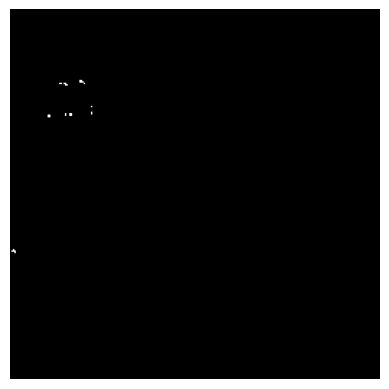

In [73]:
NUM = 4

import numpy as np
import matplotlib.pyplot as plt

# 예시로 2차원 넘파이 배열 생성
# 여기서는 10x10 크기의 무작위 이미지를 생성합니다.
# masksx = masks[NUM].cpu().detach().numpy()
masksx = np.reshape(masks[NUM],(256,256,1))
# 이미지 표시
plt.imshow(masksx, cmap='gray')  # 흑백 이미지로 표시
plt.axis('off')  # 축 제거
plt.show()

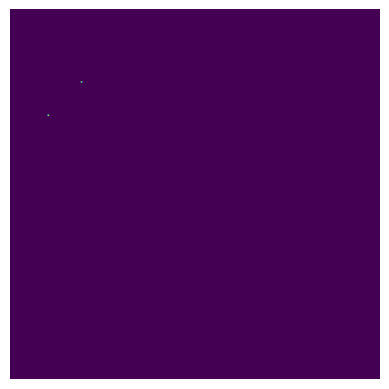

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# 예시로 2차원 넘파이 배열 생성
# 여기서는 10x10 크기의 무작위 이미지를 생성합니다.
masksx = imgs[NUM].cpu().detach().numpy()
masksx = np.reshape(masksx,(256,256,1))
# 이미지 표시
plt.imshow(masksx)  # 흑백 이미지로 표시
plt.axis('off')  # 축 제거
plt.show()

-9.050403881072995


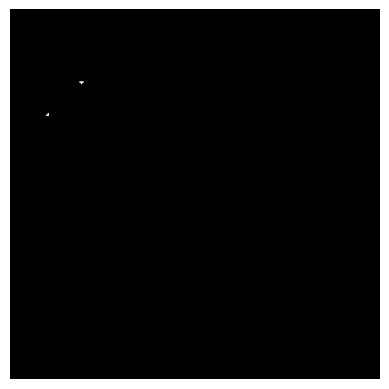

In [76]:
output = model(imgs)
masksx = output[NUM].cpu().detach().numpy()
print(np.quantile(masksx,0.99))
low = np.quantile(masksx, 0.9999)
masksx = np.where(masksx > low , 1, 0) # 임계값 처리
masksx = np.reshape(masksx,(256,256,1))
# 이미지 표시
plt.imshow(masksx, cmap='gray')  # 흑백 이미지로 표시
plt.axis('off')  # 축 제거
plt.show()

# Testing

In [325]:
num = 16266
tes = f'{BASE}/train_img/train_img_{num}.tif'
te = f'{BASE}/train_mask/train_mask_{num}.tif'

In [322]:
state = model.state_dict()

In [326]:
model = smp.DeepLabV3Plus('resnet34', encoder_weights='imagenet',classes=1, activation='sigmoid',in_channels = 1)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [1]:
import matplotlib.pyplot as plt
test_dataset = CustomDataset([tes], None, mode = 'test')

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False
)
for i in test_dataloader:
    imgs = i.to(DEVICE)
    # np.reshape(img,(256,256,1)
    out = model(imgs)
out = out[0].cpu().detach().numpy()
low = np.quantile(out, 0.99)
out = np.where(out >  low, 1, 0) # 임계값 처리
plt.imshow(np.reshape(out,(256,256,1)))

NameError: name 'CustomDataset' is not defined

# Inference

In [ ]:
y_pred_dict = {}

# data load
IMAGES_PATH = f'{BASE}/test_img/'
images_test = [os.path.join(IMAGES_PATH, image) for image in test_meta['test_img'] ]
masks_test = [os.path.join(MASKS_PATH, mask) for mask in test_meta['test_mask'] ]

test_dataset = CustomDataset(images_test, masks_test, mode = 'test')

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False
)


# load best model
# smp
model = smp.Unet('timm-mobilenetv3_large_100', encoder_weights='imagenet', classes=1, in_channels=1,activation=None)
model.load_state_dict(torch.load(MODEL_SAVE))

model.to(DEVICE)
model.eval()
with torch.no_grad():
    for idx, imgs in enumerate(tqdm(test_dataloader)):
        name = test_meta['test_img'][idx]
        imgs = imgs.to(DEVICE)
        output = model(imgs)
        
        output = output.cpu().detach().numpy()
        
        low = np.quantile(output, 0.9999)
        y_pred = np.where(output >  low, 1, 0) # 임계값 처리
        y_pred = np.reshape(y_pred,(256,256))
        
        y_pred = y_pred.astype(np.uint8)

        y_pred_dict[name] = y_pred
#
import joblib
joblib.dump(y_pred_dict, f'{BASE}/y_pred-7.pkl')

In [85]:
def get_img_test(path):
    image = tiff.imread(path)
    print(image.shape)
    img = image[:, :, (6, 5, 1)]#.astype(np.uint8)
    img = np.float32(img)/MAX_PIXEL_VALUE # 정규화
    # img = new_dataset(img)
    return np.float32(img) 

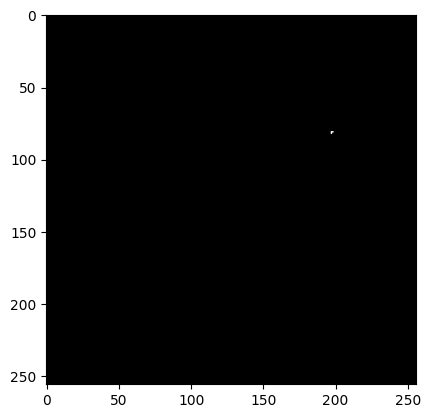

In [98]:
plt.imshow(get_mask_arr(f'{BASE}/train_mask/train_mask_2.tif'))

(256, 256, 10)


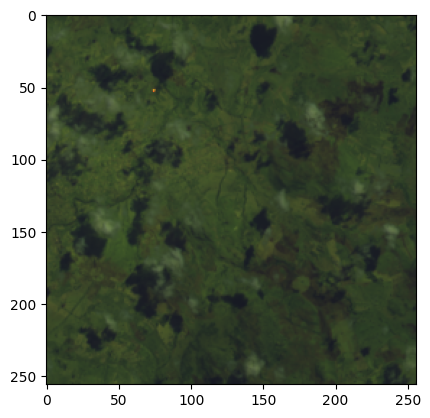

In [103]:
plt.imshow(get_img_test(f'{BASE}/test_img/test_img_2.tif'))

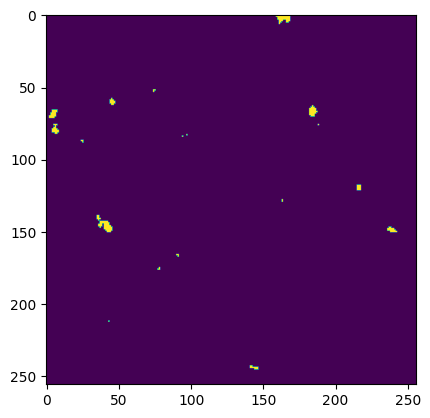

In [102]:
plt.imshow(get_img_762bands(f'{BASE}/test_img/test_img_2.tif'))

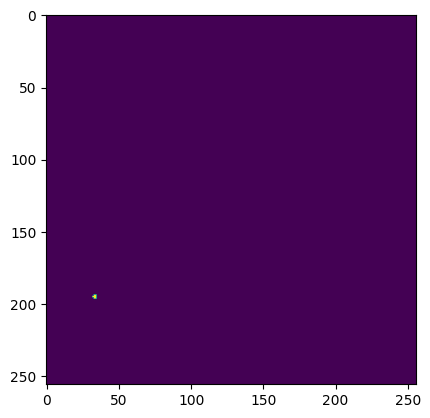

In [106]:
plt.imshow(y_pred_dict['test_img_3.tif'])

In [100]:
np.unique(y_pred_dict['test_img_3.tif'])

array([0, 1], dtype=uint8)

In [30]:
import joblib
s = joblib.load(f"{BASE}/y_pred-2.pkl")

In [31]:
s['test_img_0.tif'].shape

(256, 256)

In [105]:
np.where(y_pred_dict['test_img_3.tif'] == 1)

(array([194, 194, 195, 195, 195, 196, 196]),
 array([33, 34, 32, 33, 34, 33, 34]))